## Club Mahindra DataOlympics

### Loading Packages

In [1]:
from fastai.imports import *
from fastai.structured import *
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
from datetime import date
from IPython.display import display
pd.set_option('display.max_columns', None)
rcParams['figure.figsize'] = 12, 8
from datetime import datetime

In [73]:
import xgboost as xgb
from catboost import CatBoostRegressor, Pool, cv
import lightgbm as lgb

In [3]:
from sklearn.model_selection import KFold
from sklearn import metrics

### Custom Functions

In [4]:
def display_all(df):
    with pd.option_context("display.max_rows", 1000, "display.max_columns", 1000): 
        display(df)
        
def split_vals(a,n): return a[:n].copy(), a[n:].copy()

def get_stats(df,columns):
    fig, axs = plt.subplots(1,2)
    for column in columns:
        df2 = df[np.isfinite(df[column])]
        count, division = np.histogram(df2[column])
        null_value_stats = df[df[column].isnull()]
        print(f"Column name: {column}")
        print(f"Total Rows: {len(df)}")
        print(f"Positive values row count: {len(df[(df[column]>=0)])}")
        print(f"Negative values row count: {len(df[(df[column]<0)])}")
        print(f"Null values row count: {null_value_stats.shape[0]}")
        print(f"Column summary")
        print(df[column].describe())
        print(f"Cut: {division}")
        print(f"Count: {count}")
        df.boxplot(column=[column], ax=axs[0])
        df[column].plot.hist(bins=10, alpha=0.5, ax=axs[1])
        
def rmse(predictions, actuals): return 100*math.sqrt(((predictions-actuals)**2).mean())

dateparse = lambda x: pd.datetime.strptime(x, '%d/%m/%y')

def generate_date_features(df, fldname, drop=True):
    fld = df[fldname]
    fld_dtype = fld.dtype
    if isinstance(fld_dtype, pd.core.dtypes.dtypes.DatetimeTZDtype):
        fld_dtype = np.datetime64

    if not np.issubdtype(fld_dtype, np.datetime64):
        df[fldname] = fld = pd.to_datetime(fld, infer_datetime_format=True, errors=errors)
    targ_pre = re.sub('[Dd]ate$', '', fldname)
    attr = ['Year', 'Month', 'Week', 'Day', 'Dayofweek', 'Dayofyear',
            'Is_month_end', 'Is_month_start', 'Is_quarter_end', 'Is_quarter_start', 'Is_year_end', 'Is_year_start']
    for n in attr: df[targ_pre + n] = getattr(fld.dt, n.lower())
    df[targ_pre+"_isweekend"]=df[targ_pre+"Dayofweek"].apply(lambda x:1 if x==5 or x==6 else 0)
    if drop: df.drop(fldname, axis=1, inplace=True)
        

def fix_season_code(df, resort_id, date):
    subset = df.loc[(df['checkin_date']==date) & (df['resort_id']==resort_id)]
    rows = subset.shape[0]
    if rows > 1:
        max_reservations = np.max(subset['reservations'])
        subset=subset[subset['reservations']==max_reservations]
        return subset['season_holidayed_code'].tolist()[0]
    if rows == 1:
        return subset['season_holidayed_code'].tolist()[0]
    else:
        return 1
    
def count_encode(train, test, by_cols, on_col, name, use_test=False):
    temp=train.groupby(by_cols)[on_col].count().reset_index().rename(columns={on_col:name})
    train=pd.merge(train,temp,how='left',on=by_cols)
    if use_test:
        temp=test.groupby(by_cols)[on_col].count().reset_index().rename(columns={on_col:name})
    test=pd.merge(test,temp,how='left',on=by_cols)
    train[name].fillna(np.median(temp[name]),inplace=True)
    test[name].fillna(np.median(temp[name]),inplace=True)
    return train,test

### Loading Train and Test datasets

In [5]:
Path = './data/club_mahindra/'

In [6]:
date_columns = ['booking_date', 'checkin_date', 'checkout_date']

In [7]:
%%time
train = pd.read_csv(f'{Path}train.csv'
                         , parse_dates=date_columns
                         , date_parser=dateparse
                        )

CPU times: user 12 s, sys: 251 ms, total: 12.2 s
Wall time: 12.3 s


In [8]:
%%time
test = pd.read_csv(f'{Path}test.csv'
                        , parse_dates=date_columns
                        , date_parser=dateparse
                       )

CPU times: user 5.03 s, sys: 111 ms, total: 5.14 s
Wall time: 5.15 s


In [9]:
%%time
submission = pd.read_csv(f'{Path}sample_submission.csv')

CPU times: user 137 ms, sys: 23.6 ms, total: 161 ms
Wall time: 160 ms


In [10]:
test['amount_spent_per_room_night_scaled'] = 0

In [11]:
train.shape, test.shape, submission.shape

((341424, 24), (146765, 24), (146765, 2))

In [12]:
display_all(train.head())

,reservation_id,booking_date,checkin_date,checkout_date,channel_code,main_product_code,numberofadults,numberofchildren,persontravellingid,resort_region_code,resort_type_code,room_type_booked_code,roomnights,season_holidayed_code,state_code_residence,state_code_resort,total_pax,member_age_buckets,booking_type_code,memberid,cluster_code,reservationstatusid_code,resort_id,amount_spent_per_room_night_scaled
0,07659f3758d8aee27f5a7e2887adeacb67021cb95ada1b...,2018-04-05,2018-04-05,2018-04-06,3,1,2,0,46,3,3,3,1,2.0,7.0,3,3,F,1,3d1539e56495b6991f0a3ef5a61ca3d03ce4fff7380e9a...,F,C,4e07408562bedb8b60ce05c1decfe3ad16b72230967de0...,7.706428
1,03930f033646d073462b35d411616323597715ac4fc398...,2015-01-23,2015-04-11,2015-04-16,1,1,2,0,46,3,3,4,5,2.0,7.0,5,2,F,1,3d1539e56495b6991f0a3ef5a61ca3d03ce4fff7380e9a...,F,A,39fa9ec190eee7b6f4dff1100d6343e10918d044c75eac...,6.662563
2,d145a32920e6587ad95bfe299d80c0affa268220535aaf...,2015-01-28,2015-02-01,2015-02-05,1,1,2,0,47,1,5,4,4,2.0,7.0,1,2,F,1,3d1539e56495b6991f0a3ef5a61ca3d03ce4fff7380e9a...,E,A,535fa30d7e25dd8a49f1536779734ec8286108d115da50...,7.871602
3,cfd77f44811ed62f25a220b53324cdbafc662a4c9e5f04...,2015-05-02,2015-06-11,2015-06-16,1,1,2,2,46,2,2,3,5,2.0,7.0,2,2,F,1,3d1539e56495b6991f0a3ef5a61ca3d03ce4fff7380e9a...,D,A,d4735e3a265e16eee03f59718b9b5d03019c07d8b6c51f...,5.344943
4,937cff9e4dcfc2459620153dfc8b9962ac22bea67dfb29...,2015-09-02,2015-12-14,2015-12-19,1,1,2,0,46,2,2,4,5,2.0,7.0,2,2,F,1,3d1539e56495b6991f0a3ef5a61ca3d03ce4fff7380e9a...,D,A,d4735e3a265e16eee03f59718b9b5d03019c07d8b6c51f...,7.059346


### Generating features from date columns

In [13]:
for col in date_columns:
    generate_date_features(train, col, drop=False)
    generate_date_features(test, col, drop=False)

### Check for missing values

In [14]:
for df in (train, test):
    missing_stats = df.isnull().sum(axis=0)
    print(missing_stats[missing_stats != 0], '\n')

season_holidayed_code     114
state_code_residence     4764
dtype: int64 

season_holidayed_code      35
state_code_residence     2260
dtype: int64 



### Fix missing values

In [15]:
for df in (train, test):
    print(df.loc[df['season_holidayed_code'].isnull(),'resort_id'].unique(), '\n')

['49d180ecf56132819571bf39d9b7b342522a2ac6d23c1418d3338251bfe469c8'
 '9400f1b21cb527d7fa3d3eabba93557a18ebe7a2ca4e471cfe5e4c5b4ca7f767'
 '4b227777d4dd1fc61c6f884f48641d02b4d121d3fd328cb08b5531fcacdabf8a'] 

['49d180ecf56132819571bf39d9b7b342522a2ac6d23c1418d3338251bfe469c8'
 '4b227777d4dd1fc61c6f884f48641d02b4d121d3fd328cb08b5531fcacdabf8a'] 



- Same resorts have season_holidayed_code missing in both train and test data sets

In [16]:
missing_resorts = train.loc[train['season_holidayed_code'].isnull(),'resort_id'].unique().tolist()

In [17]:
missing_resorts_data = train[(train['resort_id'].isin(missing_resorts))
                            & (train['season_holidayed_code'].notnull())]
missing_resorts_data.shape

(45656, 63)

In [18]:
resort_season=missing_resorts_data.groupby(['resort_id'
                                           ,'checkin_date'
                                           ,'season_holidayed_code']
                                         )['reservation_id'].count().reset_index().rename(columns={'reservation_id'
                                                                                                   :'reservations'})

In [19]:
resort_season.head()

,resort_id,checkin_date,season_holidayed_code,reservations
0,49d180ecf56132819571bf39d9b7b342522a2ac6d23c14...,2012-03-08,3.0,1
1,49d180ecf56132819571bf39d9b7b342522a2ac6d23c14...,2015-01-01,1.0,10
2,49d180ecf56132819571bf39d9b7b342522a2ac6d23c14...,2015-01-02,1.0,13
3,49d180ecf56132819571bf39d9b7b342522a2ac6d23c14...,2015-01-03,1.0,6
4,49d180ecf56132819571bf39d9b7b342522a2ac6d23c14...,2015-01-04,1.0,2


In [20]:
for df in (train, test):
    df['season_holidayed_code_new'] = df.apply(lambda x: fix_season_code(resort_season
                                                                          ,x['resort_id']
                                                                          ,x['checkin_date']
                                                                          )
                                                if pd.isnull(x['season_holidayed_code']) else x['season_holidayed_code']
                                              ,axis=1)

In [21]:
sorted(train['state_code_residence'].unique().tolist())

[1.0,
 2.0,
 3.0,
 4.0,
 5.0,
 6.0,
 7.0,
 8.0,
 9.0,
 10.0,
 13.0,
 14.0,
 nan,
 11.0,
 12.0,
 15.0,
 16.0,
 18.0,
 19.0,
 20.0,
 21.0,
 22.0,
 23.0,
 24.0,
 25.0,
 26.0,
 27.0,
 28.0,
 29.0,
 30.0,
 31.0,
 32.0,
 33.0,
 34.0,
 35.0,
 36.0,
 37.0,
 38.0]

- state_code_residence 17 is missing in the data and we will impute this in the missing value

In [22]:
for df in (train, test):
    df['state_code_residence'] = df['state_code_residence'].apply(lambda x: 17 if pd.isnull(x) else x)

### Feature Engineering

In [23]:
for df in (train, test):
    df['days_advance_booking'] = (df['checkin_date'] - df['booking_date']).dt.days
    df['advance_booking_anomaly'] = df['days_advance_booking'] < 0
    df['days_stayed'] = (df['checkout_date'] - df['checkin_date']).dt.days
    df['total_guests'] = (df['numberofadults'] + df['numberofchildren'])
    df['guests_pax_ratio'] = df['total_guests']/df['total_pax']
    df['same_state_resort']= np.where(df['state_code_resort'] == df['state_code_residence'], 1, 0)
    df['roomnights'] = np.where(df['roomnights'] < 0, 1, df['roomnights'])
    df['roomsbooked'] = round(df['roomnights']/df['days_stayed'])
    df['guests_per_room'] = df['total_guests']/df['roomsbooked']
    df['peak_month'] = np.where(df['checkin_Month'].isin([4,5,12]), 1, 0)

In [24]:
full_data = train.append(test)

- Finding first booking date for each member

In [25]:
member_first_booking = full_data.groupby(['memberid'
                                  ])['booking_date'
                                  ].min().reset_index().rename(columns={'booking_date':'first_booking_date'})

In [26]:
train = pd.merge(train, member_first_booking, on='memberid', how='left')
test = pd.merge(test, member_first_booking, on='memberid', how='left')

- Feature column to know if this is the first booking of the member

In [27]:
for df in (train, test):
    df['is_first_booking'] = np.where(df['booking_date'] == df['first_booking_date'], 1, 0)

- Feature column for members doing multiple reservations on the same checkin date

In [28]:
train, test = count_encode(train
                           ,test
                           ,['memberid','checkin_date']
                           ,'reservation_id'
                           ,'same_day_reservations'
                           ,True
                          )

In [29]:
train.shape, test.shape

((341424, 76), (146765, 76))

- Feature columns to get minimum, maxiumum, mean & median number of guests travelling with a memberid

In [30]:
member_guests_size = train.groupby(['memberid'])['total_guests'].agg(['min'
                                                                      ,'max'
                                                                      ,'mean'
                                                                      ,'median'
                                                                     ]).reset_index()

member_guests_size = member_guests_size.rename(columns={'min':'min_total_guests'
                                                          ,'max':'max_total_guests'
                                                          ,'median':'median_total_guests'                                         
                                                          ,'mean':'mean_total_guests'
                                                         }
                                                )

In [31]:
train = pd.merge(train, member_guests_size, on='memberid', how='left')

In [32]:
member_guests_size = test.groupby(['memberid'])['total_guests'].agg(['min'
                                                                      ,'max'
                                                                      ,'mean'
                                                                      ,'median'
                                                                     ]).reset_index()

member_guests_size = member_guests_size.rename(columns={'min':'min_total_guests'
                                                          ,'max':'max_total_guests'
                                                          ,'median':'median_total_guests'                                         
                                                          ,'mean':'mean_total_guests'
                                                         }
                                                )

In [33]:
test = pd.merge(test, member_guests_size, on='memberid', how='left')

- Number of unique resorts booked by member

In [34]:
unique_resorts_booked = full_data.groupby(['memberid'
                                     ])['resort_id'].nunique().reset_index().rename(columns={'resort_id':
                                                                                             'unique_resorts_booked_by_member'
                                                                                            })

In [35]:
train = pd.merge(train, unique_resorts_booked, on='memberid', how='left')
test = pd.merge(test, unique_resorts_booked, on='memberid', how='left')

- Removing reservationstatusid_code with has only one instance

In [36]:
train['reservationstatusid_code'].value_counts()

A    312481
B     14811
C     14131
D         1
Name: reservationstatusid_code, dtype: int64

In [37]:
test['reservationstatusid_code'].value_counts()

A    134262
B      6429
C      6074
Name: reservationstatusid_code, dtype: int64

In [38]:
train = train[train['reservationstatusid_code'] != 'D']

- Counting numbers of resorts in each region

In [39]:
resorts_in_region = full_data.groupby(['resort_region_code'
                                      ])['resort_id'].nunique().reset_index().rename(columns={'resort_id':
                                                                                      'num_resorts_region'})

In [40]:
train = pd.merge(train, resorts_in_region, on='resort_region_code', how='left')
test = pd.merge(test, resorts_in_region, on='resort_region_code', how='left')

- Resorts booked in a region on a specific date

In [ ]:
resorts_booked_in_region = full_data.groupby(['resort_region_code','checkin_date'
                                             ])['resort_id'].nunique().reset_index().rename(columns={'resort_id':
                                                                                                    'num_resorts_booked'
                                                                                                    }
                                                                                           )

In [42]:
train = pd.merge(train, resorts_booked_in_region, on=['resort_region_code', 'checkin_date'], how='left')
test = pd.merge(test, resorts_booked_in_region, on=['resort_region_code', 'checkin_date'], how='left')

- Percent of resorts booked in a region on a specific date

In [43]:
for df in (train, test):
    df['resorts_booked_region_percent'] = df['num_resorts_booked']/df['num_resorts_region']

In [44]:
display_all(train.head())

,reservation_id,booking_date,checkin_date,checkout_date,channel_code,main_product_code,numberofadults,numberofchildren,persontravellingid,resort_region_code,resort_type_code,room_type_booked_code,roomnights,season_holidayed_code,state_code_residence,state_code_resort,total_pax,member_age_buckets,booking_type_code,memberid,cluster_code,reservationstatusid_code,resort_id,amount_spent_per_room_night_scaled,booking_Year,booking_Month,booking_Week,booking_Day,booking_Dayofweek,booking_Dayofyear,booking_Is_month_end,booking_Is_month_start,booking_Is_quarter_end,booking_Is_quarter_start,booking_Is_year_end,booking_Is_year_start,booking__isweekend,checkin_Year,checkin_Month,checkin_Week,checkin_Day,checkin_Dayofweek,checkin_Dayofyear,checkin_Is_month_end,checkin_Is_month_start,checkin_Is_quarter_end,checkin_Is_quarter_start,checkin_Is_year_end,checkin_Is_year_start,checkin__isweekend,checkout_Year,checkout_Month,checkout_Week,checkout_Day,checkout_Dayofweek,checkout_Dayofyear,checkout_Is_month_end,checkout_Is_month_start,checkout_Is_quarter_end,checkout_Is_quarter_start,checkout_Is_year_end,checkout_Is_year_start,checkout__isweekend,season_holidayed_code_new,days_advance_booking,advance_booking_anomaly,days_stayed,total_guests,guests_pax_ratio,same_state_resort,roomsbooked,guests_per_room,peak_month,first_booking_date,is_first_booking,same_day_reservations,min_total_guests,max_total_guests,mean_total_guests,median_total_guests,unique_resorts_booked_by_member,num_resorts_region,num_resorts_booked,resorts_booked_region_percent
0,07659f3758d8aee27f5a7e2887adeacb67021cb95ada1b...,2018-04-05,2018-04-05,2018-04-06,3,1,2,0,46,3,3,3,1,2.0,7.0,3,3,F,1,3d1539e56495b6991f0a3ef5a61ca3d03ce4fff7380e9a...,F,C,4e07408562bedb8b60ce05c1decfe3ad16b72230967de0...,7.706428,2018,4,14,5,3,95,False,False,False,False,False,False,0,2018,4,14,5,3,95,False,False,False,False,False,False,0,2018,4,14,6,4,96,False,False,False,False,False,False,0,2.0,0,False,1,2,0.666667,0,1.0,2.0,1,2015-01-23,0,1,2,4,2.285714,2.0,10,10,10,1.00
1,03930f033646d073462b35d411616323597715ac4fc398...,2015-01-23,2015-04-11,2015-04-16,1,1,2,0,46,3,3,4,5,2.0,7.0,5,2,F,1,3d1539e56495b6991f0a3ef5a61ca3d03ce4fff7380e9a...,F,A,39fa9ec190eee7b6f4dff1100d6343e10918d044c75eac...,6.662563,2015,1,4,23,4,23,False,False,False,False,False,False,0,2015,4,15,11,5,101,False,False,False,False,False,False,1,2015,4,16,16,3,106,False,False,False,False,False,False,0,2.0,78,False,5,2,1.000000,0,1.0,2.0,1,2015-01-23,1,1,2,4,2.285714,2.0,10,10,8,0.80
2,d145a32920e6587ad95bfe299d80c0affa268220535aaf...,2015-01-28,2015-02-01,2015-02-05,1,1,2,0,47,1,5,4,4,2.0,7.0,1,2,F,1,3d1539e56495b6991f0a3ef5a61ca3d03ce4fff7380e9a...,E,A,535fa30d7e25dd8a49f1536779734ec8286108d115da50...,7.871602,2015,1,5,28,2,28,False,False,False,False,False,False,0,2015,2,5,1,6,32,False,True,False,False,False,False,1,2015,2,6,5,3,36,False,False,False,False,False,False,0,2.0,4,False,4,2,1.000000,0,1.0,2.0,0,2015-01-23,0,1,2,4,2.285714,2.0,10,12,9,0.75
3,cfd77f44811ed62f25a220b53324cdbafc662a4c9e5f04...,2015-05-02,2015-06-11,2015-06-16,1,1,2,2,46,2,2,3,5,2.0,7.0,2,2,F,1,3d1539e56495b6991f0a3ef5a61ca3d03ce4fff7380e9a...,D,A,d4735e3a265e16eee03f59718b9b5d03019c07d8b6c51f...,5.344943,2015,5,18,2,5,122,False,False,False,False,False,False,1,2015,6,24,11,3,162,False,False,False,False,False,False,0,2015,6,25,16,1,167,False,False,False,False,False,False,0,2.0,40,False,5,4,2.000000,0,1.0,4.0,0,2015-01-23,0,1,2,4,2.285714,2.0,10,10,7,0.70
4,937cff9e4dcfc2459620153dfc8b9962ac22bea67dfb29...,2015-09-02,2015-12-14,2015-12-19,1,1,2,0,46,2,2,4,5,2.0,7.0,2,2,F,1,3d1539e56495b6991f0a3ef5a61ca3d03ce4fff7380e9a...,D,A,d4735e3a265e16eee03f59718b9b5d03019c07d8b6c51f...,7.059346,2015,9,36,2,2,245,False,False,False,False,False,False,0,2015,12,51,14,0,348,False,False,False,False,False,False,0,2015,12,51,19,5,353,False,False,False,False,False,False,1,2.0,103,False,5,2,1.000000,0,1.0,2.0,1,2015-01-23,0,1,2,4,2.285714,2.0,10,10,7,0.70


In [45]:
unwanted_columns = ['booking_date'
                   ,'checkin_date'
                   ,'checkout_date'
                   ,'first_booking_date'
                   ,'memberid'
                   ,'season_holidayed_code'
                   ]

In [46]:
categorical_columns = [
    'channel_code'
    ,'main_product_code'
    ,'persontravellingid'
    ,'resort_region_code'
    ,'resort_type_code'
    ,'room_type_booked_code'
    ,'state_code_residence'
    ,'state_code_resort'
    ,'booking_type_code'
    ,'season_holidayed_code_new'
]

- Remove unwanted columns

In [47]:
for df in (train, test):
    df.drop(unwanted_columns, axis=1, inplace=True)

- Converting code columns to object data type

In [48]:
for df in (train, test):
    for col in df.columns:
        if col in categorical_columns: df[col] = df[col].apply(str)

In [49]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 341423 entries, 0 to 341422
Data columns (total 78 columns):
reservation_id                        341423 non-null object
channel_code                          341423 non-null object
main_product_code                     341423 non-null object
numberofadults                        341423 non-null int64
numberofchildren                      341423 non-null int64
persontravellingid                    341423 non-null object
resort_region_code                    341423 non-null object
resort_type_code                      341423 non-null object
room_type_booked_code                 341423 non-null object
roomnights                            341423 non-null int64
state_code_residence                  341423 non-null object
state_code_resort                     341423 non-null object
total_pax                             341423 non-null int64
member_age_buckets                    341423 non-null object
booking_type_code                     3

- Converting objects to category datatype

In [50]:
train_cats(train)
apply_cats(test, train)

- Final preprocessing train & test dataframes for modeling purposes

In [51]:
df_train, y, nas = proc_df(train, 'amount_spent_per_room_night_scaled', skip_flds=['reservation_id'])
df_test, _, nas = proc_df(test, 'amount_spent_per_room_night_scaled', skip_flds=['reservation_id'])

In [52]:
df_train.head()

,channel_code,main_product_code,numberofadults,numberofchildren,persontravellingid,resort_region_code,resort_type_code,room_type_booked_code,roomnights,state_code_residence,state_code_resort,total_pax,member_age_buckets,booking_type_code,cluster_code,reservationstatusid_code,resort_id,booking_Year,booking_Month,booking_Week,booking_Day,booking_Dayofweek,booking_Dayofyear,booking_Is_month_end,booking_Is_month_start,booking_Is_quarter_end,booking_Is_quarter_start,booking_Is_year_end,booking_Is_year_start,booking__isweekend,checkin_Year,checkin_Month,checkin_Week,checkin_Day,checkin_Dayofweek,checkin_Dayofyear,checkin_Is_month_end,checkin_Is_month_start,checkin_Is_quarter_end,checkin_Is_quarter_start,checkin_Is_year_end,checkin_Is_year_start,checkin__isweekend,checkout_Year,checkout_Month,checkout_Week,checkout_Day,checkout_Dayofweek,checkout_Dayofyear,checkout_Is_month_end,checkout_Is_month_start,checkout_Is_quarter_end,checkout_Is_quarter_start,checkout_Is_year_end,checkout_Is_year_start,checkout__isweekend,season_holidayed_code_new,days_advance_booking,advance_booking_anomaly,days_stayed,total_guests,guests_pax_ratio,same_state_resort,roomsbooked,guests_per_room,peak_month,is_first_booking,same_day_reservations,min_total_guests,max_total_guests,mean_total_guests,median_total_guests,unique_resorts_booked_by_member,num_resorts_region,num_resorts_booked,resorts_booked_region_percent
0,3,1,2,0,2,3,4,3,1,36,6,3,6,1,6,3,8,2018,4,14,5,3,95,False,False,False,False,False,False,0,2018,4,14,5,3,95,False,False,False,False,False,False,0,2018,4,14,6,4,96,False,False,False,False,False,False,0,2,0,False,1,2,0.666667,0,1.0,2.0,1,0,1,2,4,2.285714,2.0,10,10,10,1.00
1,1,1,2,0,2,3,4,4,5,36,8,2,6,1,6,1,2,2015,1,4,23,4,23,False,False,False,False,False,False,0,2015,4,15,11,5,101,False,False,False,False,False,False,1,2015,4,16,16,3,106,False,False,False,False,False,False,0,2,78,False,5,2,1.000000,0,1.0,2.0,1,1,1,2,4,2.285714,2.0,10,10,8,0.80
2,1,1,2,0,3,1,6,4,4,36,1,2,6,1,5,1,10,2015,1,5,28,2,28,False,False,False,False,False,False,0,2015,2,5,1,6,32,False,True,False,False,False,False,1,2015,2,6,5,3,36,False,False,False,False,False,False,0,2,4,False,4,2,1.000000,0,1.0,2.0,0,0,1,2,4,2.285714,2.0,10,12,9,0.75
3,1,1,2,2,2,2,3,3,5,36,5,2,6,1,4,1,26,2015,5,18,2,5,122,False,False,False,False,False,False,1,2015,6,24,11,3,162,False,False,False,False,False,False,0,2015,6,25,16,1,167,False,False,False,False,False,False,0,2,40,False,5,4,2.000000,0,1.0,4.0,0,0,1,2,4,2.285714,2.0,10,10,7,0.70
4,1,1,2,0,2,2,3,4,5,36,5,2,6,1,4,1,26,2015,9,36,2,2,245,False,False,False,False,False,False,0,2015,12,51,14,0,348,False,False,False,False,False,False,0,2015,12,51,19,5,353,False,False,False,False,False,False,1,2,103,False,5,2,1.000000,0,1.0,2.0,1,0,1,2,4,2.285714,2.0,10,10,7,0.70


## LightGBM Model - 5 fold crossvalidation

In [53]:
%%time
err_lgb=[]
y_pred_tot_lgb=[]
fold=KFold(n_splits=5, shuffle=True, random_state=1994)
for train_idx, test_idx in fold.split(df_train, y):
    X_train, X_test = df_train.iloc[train_idx], df_train.iloc[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    params = {
        "objective" : "regression",
        "metric" : "rmse",
        "boosting": "gbdt",
        "max_depth" : 6,
        "learning_rate" : 0.01,
        "feature_fraction" : 0.5,
        "num_leaves" : 64,
        "verbosity" : -1
    }
    lgtrain = lgb.Dataset(X_train, y_train)
    lgval = lgb.Dataset(X_test, y_test)
    model = lgb.train(params
                      , lgtrain
                      , 3000
                      , valid_sets = [lgval, lgtrain]
                      , valid_names = ['valid', 'train']
                      , early_stopping_rounds=30
                      , verbose_eval=100
                     )
    preds=model.predict(X_test, num_iteration=model.best_iteration)
    preds[preds < 0] = 0
    print("rmse: ",rmse(preds, y_test))
    err_lgb.append(rmse(preds, y_test))
    p = model.predict(df_test, num_iteration=model.best_iteration)
    p[p < 0] = 0
    y_pred_tot_lgb.append(p)

Training until validation scores don't improve for 30 rounds.
[100]	train's rmse: 1.01864	valid's rmse: 1.01449
[200]	train's rmse: 0.994605	valid's rmse: 0.991328
[300]	train's rmse: 0.982797	valid's rmse: 0.980615
[400]	train's rmse: 0.975986	valid's rmse: 0.974989
[500]	train's rmse: 0.970919	valid's rmse: 0.971161
[600]	train's rmse: 0.967413	valid's rmse: 0.968891
[700]	train's rmse: 0.964547	valid's rmse: 0.967271
[800]	train's rmse: 0.962154	valid's rmse: 0.966093
[900]	train's rmse: 0.960167	valid's rmse: 0.965318
[1000]	train's rmse: 0.958488	valid's rmse: 0.96476
[1100]	train's rmse: 0.956948	valid's rmse: 0.964294
[1200]	train's rmse: 0.955558	valid's rmse: 0.963929
[1300]	train's rmse: 0.954256	valid's rmse: 0.963637
[1400]	train's rmse: 0.95304	valid's rmse: 0.963383
[1500]	train's rmse: 0.951928	valid's rmse: 0.963176
[1600]	train's rmse: 0.95087	valid's rmse: 0.963011
[1700]	train's rmse: 0.949804	valid's rmse: 0.962869
[1800]	train's rmse: 0.948709	valid's rmse: 0.96276

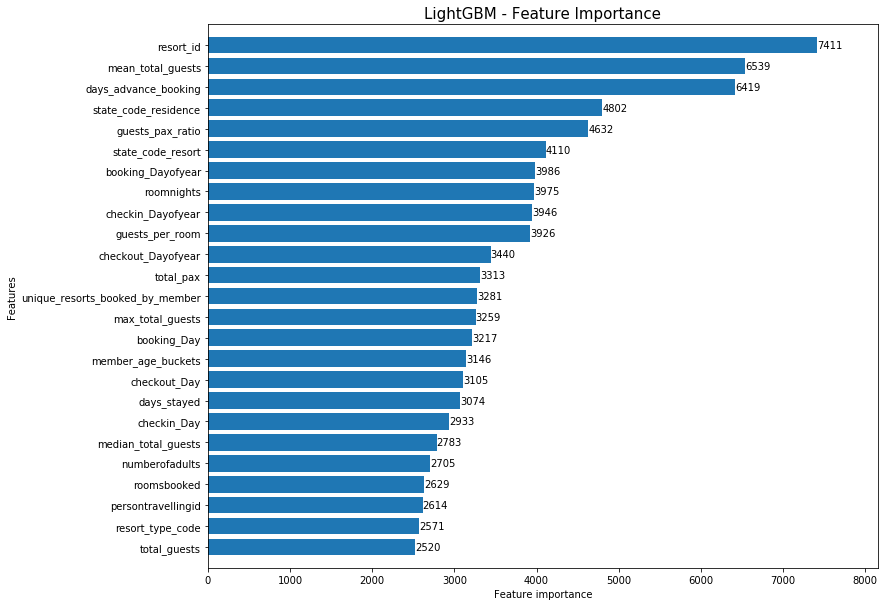

In [54]:
fig, ax = plt.subplots(figsize=(12,10))
lgb.plot_importance(model, max_num_features=25, height=0.8, ax=ax)
ax.grid(False)
plt.title("LightGBM - Feature Importance", fontsize=15)
plt.show()

In [55]:
print(np.mean(err_lgb,0))

96.88290556479197


In [56]:
submission['amount_spent_per_room_night_scaled'] = np.mean(y_pred_tot_lgb,0)
submission.head()

,reservation_id,amount_spent_per_room_night_scaled
0,7dae1ce6bc8f69481328f2be5c4943077dad5598b5f66d...,8.084208
1,fe0d4e444e1818436c88f72f1cf800536c2f785e59baeb...,7.442819
2,540bd4285ad8168e8388f84ee74a82cd4f97dc0a404d3e...,7.528181
3,09593c907ae262e46f655b4db9e14f54a19eadcfdd2679...,7.881331
4,f4c50caac68051faf37551d70bb17eebef2a20e2244cb1...,7.831161


## Catboost Model - 5 fold crossvalidation

In [57]:
cat_idxs = []
for col in categorical_columns:
    col_idx = df_train.columns.get_loc(col)
    cat_idxs.append(col_idx)

In [58]:
%%time
errcb=[]
y_pred_totcb=[]
fold=KFold(n_splits=5, shuffle=True, random_state=1994)
for train_idx, test_idx in fold.split(df_train, y):
    X_train, X_test = df_train.iloc[train_idx], df_train.iloc[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    model=CatBoostRegressor(n_estimators=3000
                            ,random_state=1994
                            ,eval_metric='RMSE'
                            ,max_depth=6
                            ,learning_rate=0.01
                            ,od_wait=30
                            ,cat_features=cat_idxs
                            ,use_best_model=True
                            ,colsample_bylevel=0.5
                           )
    model.fit(X_train , y_train
              , eval_set=[(X_test, y_test)]
              , early_stopping_rounds=50
#               , plot = True
              , verbose = 250)
    preds=model.predict(X_test)
    preds[preds < 0] = 0
    print("rmse: ",rmse(preds, y_test))
    errcb.append(rmse(preds, y_test))
    p = model.predict(df_test)
    p[p < 0] = 0
    y_pred_totcb.append(p)

0:	learn: 7.7208159	test: 7.7215052	best: 7.7215052 (0)	total: 169ms	remaining: 8m 27s
250:	learn: 1.1965928	test: 1.1937506	best: 1.1937506 (250)	total: 29.6s	remaining: 5m 23s
500:	learn: 0.9889409	test: 0.9830581	best: 0.9830581 (500)	total: 1m	remaining: 4m 59s
750:	learn: 0.9792130	test: 0.9733445	best: 0.9733445 (750)	total: 1m 32s	remaining: 4m 36s
1000:	learn: 0.9756621	test: 0.9701762	best: 0.9701762 (1000)	total: 2m 3s	remaining: 4m 5s
1250:	learn: 0.9735644	test: 0.9685798	best: 0.9685798 (1250)	total: 2m 33s	remaining: 3m 35s
1500:	learn: 0.9718184	test: 0.9674236	best: 0.9674236 (1500)	total: 3m 4s	remaining: 3m 3s
1750:	learn: 0.9703676	test: 0.9665428	best: 0.9665428 (1750)	total: 3m 33s	remaining: 2m 32s
2000:	learn: 0.9692082	test: 0.9659835	best: 0.9659835 (2000)	total: 4m 4s	remaining: 2m 1s
2250:	learn: 0.9681804	test: 0.9655113	best: 0.9655113 (2250)	total: 4m 34s	remaining: 1m 31s
2500:	learn: 0.9672316	test: 0.9651328	best: 0.9651328 (2500)	total: 5m 4s	remaining

In [59]:
print(np.mean(errcb,0)) 

97.09361367641054


In [60]:
fstrs = model.get_feature_importance(prettified=True)
feature_df = pd.DataFrame(fstrs,columns=['Feature','Score'])
display_all(feature_df.head(25))

,Feature,Score
0,days_stayed,16.453808
1,roomsbooked,14.802799
2,total_pax,7.916660
3,same_day_reservations,7.239686
4,state_code_resort,7.080890
5,resort_id,6.041664
6,persontravellingid,5.742414
7,main_product_code,3.448363
8,total_guests,2.900997
9,numberofadults,2.673143


In [61]:
submission['amount_spent_per_room_night_scaled'] = np.mean(y_pred_totcb,0)
submission.head()

,reservation_id,amount_spent_per_room_night_scaled
0,7dae1ce6bc8f69481328f2be5c4943077dad5598b5f66d...,8.067269
1,fe0d4e444e1818436c88f72f1cf800536c2f785e59baeb...,7.390584
2,540bd4285ad8168e8388f84ee74a82cd4f97dc0a404d3e...,7.504954
3,09593c907ae262e46f655b4db9e14f54a19eadcfdd2679...,7.815707
4,f4c50caac68051faf37551d70bb17eebef2a20e2244cb1...,7.786086


## XGBoost Model - 5 fold crossvalidation

In [62]:
%%time
err_xgb=[]
y_pred_tot_xgb=[]
fold=KFold(n_splits=5, shuffle=True, random_state=1994)
for train_idx, test_idx in fold.split(df_train, y):
    X_train, X_test = df_train.iloc[train_idx], df_train.iloc[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    params = {
        "eval_metric" : "rmse",
        "max_depth" : 6,
        "max_leaves": 64,
        "learning_rate" : 0.01,
        "colsample_bytree" : 0.5
    }
    xgtrain = xgb.DMatrix(X_train, y_train)
    xgval = xgb.DMatrix(X_test, y_test)
    model = xgb.train(params
                      , xgtrain
                      , 3000
                      , early_stopping_rounds=30
                      , evals=[(xgval, 'valid'), (xgtrain, 'train')]
                      , verbose_eval=100
                     )
    preds=model.predict(xgb.DMatrix(X_test), model.best_iteration)
    preds[preds < 0] = 0
    print("rmse: ",rmse(preds, y_test))
    err_xgb.append(rmse(preds, y_test))
    p = model.predict(xgb.DMatrix(df_test), model.best_iteration)
    p[p < 0] = 0
    y_pred_tot_xgb.append(p)

[0]	valid-rmse:7.23159	train-rmse:7.23092
Multiple eval metrics have been passed: 'train-rmse' will be used for early stopping.

Will train until train-rmse hasn't improved in 30 rounds.
[100]	valid-rmse:2.80987	train-rmse:2.80827
[200]	valid-rmse:1.38133	train-rmse:1.38051
[300]	valid-rmse:1.04303	train-rmse:1.04309
[400]	valid-rmse:0.983794	train-rmse:0.983553
[500]	valid-rmse:0.97248	train-rmse:0.971343
[600]	valid-rmse:0.968987	train-rmse:0.966626
[700]	valid-rmse:0.967271	train-rmse:0.963602
[800]	valid-rmse:0.96617	train-rmse:0.961147
[900]	valid-rmse:0.965482	train-rmse:0.959078
[1000]	valid-rmse:0.964931	train-rmse:0.957253
[1100]	valid-rmse:0.964481	train-rmse:0.955536
[1200]	valid-rmse:0.964131	train-rmse:0.953943
[1300]	valid-rmse:0.963858	train-rmse:0.95247
[1400]	valid-rmse:0.963634	train-rmse:0.951178
[1500]	valid-rmse:0.963452	train-rmse:0.949966
[1600]	valid-rmse:0.96332	train-rmse:0.948745
[1700]	valid-rmse:0.963167	train-rmse:0.947622
[1800]	valid-rmse:0.963073	train-

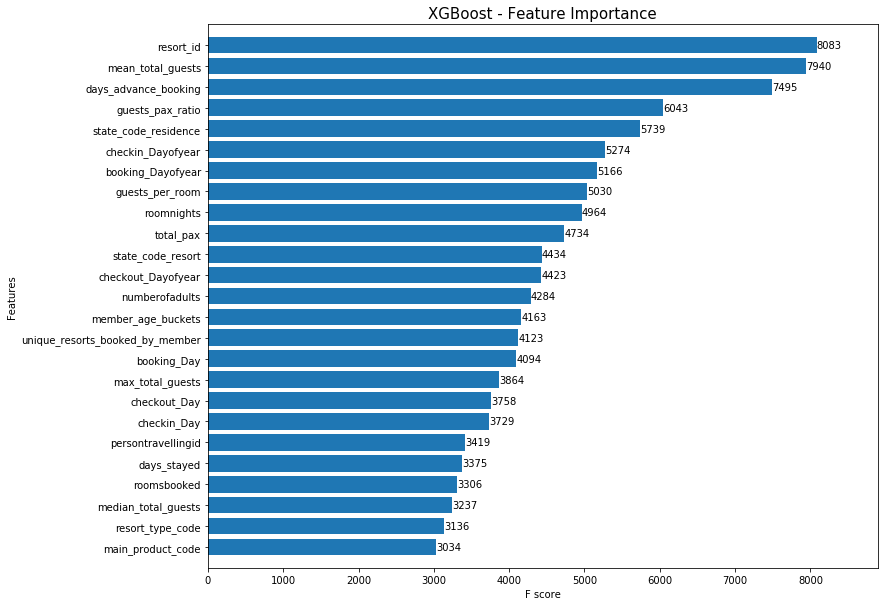

In [63]:
fig, ax = plt.subplots(figsize=(12,10))
xgb.plot_importance(model, max_num_features=25, height=0.8, ax=ax)
ax.grid(False)
plt.title("XGBoost - Feature Importance", fontsize=15)
plt.show()

In [64]:
print(np.mean(err_xgb,0))

96.8963660231864


In [65]:
submission['amount_spent_per_room_night_scaled'] = np.mean(y_pred_tot_xgb,0)
submission.head()

,reservation_id,amount_spent_per_room_night_scaled
0,7dae1ce6bc8f69481328f2be5c4943077dad5598b5f66d...,8.056815
1,fe0d4e444e1818436c88f72f1cf800536c2f785e59baeb...,7.425322
2,540bd4285ad8168e8388f84ee74a82cd4f97dc0a404d3e...,7.527915
3,09593c907ae262e46f655b4db9e14f54a19eadcfdd2679...,7.873869
4,f4c50caac68051faf37551d70bb17eebef2a20e2244cb1...,7.833684


## Blender Model with LGBM, CATBoost & XGBoost

- Mean RMSE score for 3 models

In [71]:
np.mean([np.mean(err_lgb,0)
        ,np.mean(errcb,0)
        ,np.mean(err_xgb,0)
        ])

96.95762842146297

In [66]:
blender_submission = submission[['reservation_id']]
blender_submission['lgb_pred'] = np.mean(y_pred_tot_lgb,0)
blender_submission['cb_pred'] = np.mean(y_pred_totcb,0)
blender_submission['xgb_pred'] = np.mean(y_pred_tot_xgb,0)
blender_submission['amount_spent_per_room_night_scaled'] = (blender_submission['lgb_pred']
                                                           + blender_submission['cb_pred']
                                                           + blender_submission['xgb_pred']
                                                           )/3

In [67]:
blender_submission.head()

,reservation_id,lgb_pred,cb_pred,xgb_pred,amount_spent_per_room_night_scaled
0,7dae1ce6bc8f69481328f2be5c4943077dad5598b5f66d...,8.084208,8.067269,8.056815,8.069431
1,fe0d4e444e1818436c88f72f1cf800536c2f785e59baeb...,7.442819,7.390584,7.425322,7.419575
2,540bd4285ad8168e8388f84ee74a82cd4f97dc0a404d3e...,7.528181,7.504954,7.527915,7.520350
3,09593c907ae262e46f655b4db9e14f54a19eadcfdd2679...,7.881331,7.815707,7.873869,7.856969
4,f4c50caac68051faf37551d70bb17eebef2a20e2244cb1...,7.831161,7.786086,7.833684,7.816977


In [68]:
blender_submission = blender_submission[['reservation_id', 'amount_spent_per_room_night_scaled']]

In [72]:
file_timestamp = datetime.now().strftime('%m%d%Y_%H%M')
model_name='Blender'
blender_submission.to_csv(f'{Path}{model_name}_Submission_{file_timestamp}.csv', index=False)